In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

#### 데이터 준비

In [2]:
df = pd.read_csv('C:/Users/EL087/Desktop/MS_MachineLearning/data/RocketLaunchDataCompleted2.csv', encoding='cp949')
df.head()

,Crewed or Uncrewed,Launched?,High Temp,Low Temp,Ave Temp,Hist High Temp,Hist Low Temp,Hist Ave Temp,Percipitation at Launch Time,Hist Ave Percipitation,Wind Direction,Max Wind Speed,Visibility,Condition,target
0,Uncrewed,N,75.0,68.0,71.00,75.0,55.0,65.0,0.0,0.08,E,16.0,15.0,Cloudy,0
1,Uncrewed,N,78.0,70.0,73.39,75.0,55.0,65.0,0.0,0.09,E,14.0,10.0,Cloudy,0
2,Uncrewed,Y,73.0,0.0,60.21,75.0,55.0,65.0,0.0,0.09,NE,15.0,10.0,Cloudy,1
3,Uncrewed,N,76.0,57.0,66.04,75.0,55.0,65.0,0.0,0.08,N,10.0,10.0,Partly Cloudy,0
4,Uncrewed,N,79.0,60.0,70.52,75.0,55.0,65.0,0.0,0.09,E,12.0,10.0,Partly Cloudy,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Crewed or Uncrewed            300 non-null    object 
 1   Launched?                     300 non-null    object 
 2   High Temp                     300 non-null    float64
 3   Low Temp                      300 non-null    float64
 4   Ave Temp                      300 non-null    float64
 5   Hist High Temp                300 non-null    float64
 6   Hist Low Temp                 300 non-null    float64
 7   Hist Ave Temp                 300 non-null    float64
 8   Percipitation at Launch Time  300 non-null    float64
 9   Hist Ave Percipitation        300 non-null    float64
 10  Wind Direction                300 non-null    object 
 11  Max Wind Speed                300 non-null    float64
 12  Visibility                    300 non-null    float64
 13  Condi

### 독립변수, 종속변수 지정

In [4]:
X = df.drop(['Launched?', 'target'], axis=1)
y = df['target']

In [5]:
# -----------------
# 데이터 유형 파악
# -----------------
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include='number').columns

### 훈련세트/테스트세트 분할

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((225, 13), (75, 13), (225,), (75,))

### 전처리 파이프라인

In [7]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# -----------------------------
# ColumnTransformer 구성
#   - "cat" : 범주형 → OneHotEncoder
#   - "num" : 수치형 → StandardScaler
#   remainder="passthrough" : transformers에 포함되지 않은 컬럼은 변환 없이 그대로 유지
# -----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ],
    remainder="passthrough"   # drop 으로 바꾸면 나머지 컬럼을 제거
)

### 훈련 및 평가

In [8]:
# --------------------------------------------
# 파이프라인 정의
# --------------------------------------------
from sklearn.pipeline import Pipeline       
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(class_weight='balanced'))
])

- class_weight='balanced'

    RandomForestClassifier (또는 다른 많은 scikit-learn 분류 모델)에게 데이터셋의 클래스 불균형을 자동으로 보정하도록 지시

    **가중치 계산**: 각 클래스의 샘플 수에 반비례하는 가중치를 계산
    - 샘플 수가 적은 클래스에는 높은 가중치를 부여
    - 샘플 수가 많은 클래스에는 낮은 가중치를 부여

    **학습 보정**: 모델(여기서는 결정 트리)이 샘플 수가 적은 클래스의 데이터를 잘못 분류했을 때 더 큰 페널티를 부여하도록 조정

    결론: 이를 통해 모델은 소수 클래스의 샘플을 학습할 때 더 집중하게 되어,  
    결과적으로 두 클래스에 대한 예측 성능의 균형을 맞추고 **재현율(Recall)**을 개선하는 데 도움을 줌

In [9]:
# --------------------------------------------
# 훈련
# --------------------------------------------
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [10]:
# ---------------------------
# 정확도
# ---------------------------
pipeline.score(X_test, y_test)

0.8133333333333334

In [11]:
from sklearn.metrics import classification_report
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90        60
           1       1.00      0.07      0.12        15

    accuracy                           0.81        75
   macro avg       0.91      0.53      0.51        75
weighted avg       0.85      0.81      0.74        75



In [12]:
# 혼동 행렬 계산
from sklearn.metrics import confusion_matrix
y_pred = pipeline.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[60,  0],
       [14,  1]])

📊 혼동 행렬 분석

<br>

| | **모델 예측: 0 (실패)** | **모델 예측: 1 (성공)** |
| :---: | :---: | :---: |
| **실제 정답: 0 (실패)** | TN (60) | FP (0) |
| **실제 정답: 1 (성공)** | FN (14) | TP (1) |

🔍 각 값의 의미

- TN (True Negative, 60): 실제 실패(0)를 모델이 실패(0)로 올바르게 예측한 횟수. (가장 많음)

- FP (False Positive, 0): 실제 실패(0)인데 모델이 성공(1)으로 잘못 예측한 횟수. (매우 좋음)

- FN (False Negative, 14): 실제 성공(1)인데 모델이 실패(0)로 잘못 예측한 횟수. (**가장 큰 문제**)

- TP (True Positive, 1): 실제 성공(1)을 모델이 성공(1)으로 올바르게 예측한 횟수. (매우 적음)

📉 이 모델의 성능 평가

이 혼동 행렬을 통해 이 파이프라인이 심각한 불균형 문제를 겪고 있음을 알 수 있음

**1. 높은 정확도 (Accuracy)의 함정**

- 총 데이터 수: $60 + 0 + 14 + 1 = 75$개

- 정확하게 예측한 수 (TP + TN): $60 + 1 = 61$개

- 정확도: $61 / 75 \approx 81.3\%$
    - 겉으로 보기에는 **81.3%**로 높게 나오지만, 이는 대부분의 데이터가 실패(0)이고 모델이 실패(0)를 잘 맞췄기(TN=60) 때문
    
**2. 성공 예측 능력 (재현율)의 실패**

 이 모델의 가장 큰 문제는 **실제 성공(1)**에 대한 예측 능력

- 실제 성공 사례: $14 + 1 = 15$개

- 재현율 (Recall) - 성공(1) 클래스: $\text{TP} / (\text{TP} + \text{FN}) = 1 / (1 + 14) = 1 / 15 \approx **6.7\%**$

    모델은 실제 성공해야 할 15건 중 단 1건만 올바르게 예측하고, 나머지 14건은 실패라고 잘못 예측

**3. 결론**

이 모델은 실패(0) 예측에서는 매우 뛰어나지만 (오탐율 0%), 성공(1) 예측에 대해서는 거의 능력이 없는 수준  
class_weight='balanced'를 설정했음에도 불구하고, 여전히 소수 클래스인 성공(1)을 제대로 학습하지 못하고 있음

다음 단계: 이 문제를 해결하기 위해 XGBoost와 같은 다른 강력한 모델을 사용하거나,  
하이퍼파라미터 튜닝 및 **오버샘플링(Oversampling)**과 같은 고급 불균형 처리 기법을 시도해야 함

### pipeline에서 모델의 학습결과 확인
* 파이프라인에서 각 스텝의 결과 가져오기
    - `pipeline.named_steps['단계명']`

In [13]:
# ------------------------------
# 모델 객체 가져오기
# ------------------------------
model = pipeline.named_steps['rf']

In [14]:
# ------------------------------
# 모델이 학습한 결과 확인 - 특성의 중요도
# ------------------------------
importance = model.feature_importances_
importance


array([0.07659158, 0.07141678, 0.02000697, 0.00680234, 0.01532043,
       0.01155869, 0.00750589, 0.01490268, 0.00750834, 0.00089807,
       0.01320243, 0.02011506, 0.00272091, 0.01677187, 0.00091098,
       0.00029461, 0.0005178 , 0.00451711, 0.02431505, 0.00430909,
       0.00553452, 0.00107085, 0.08670592, 0.06116315, 0.12366921,
       0.05046641, 0.05541983, 0.04974254, 0.05128091, 0.06472669,
       0.07314067, 0.0568926 ])

In [15]:
# ------------------------------
# 모델이 학습한 결과 확인 - feature_names
# ------------------------------
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

<Axes: ylabel='feature_names'>

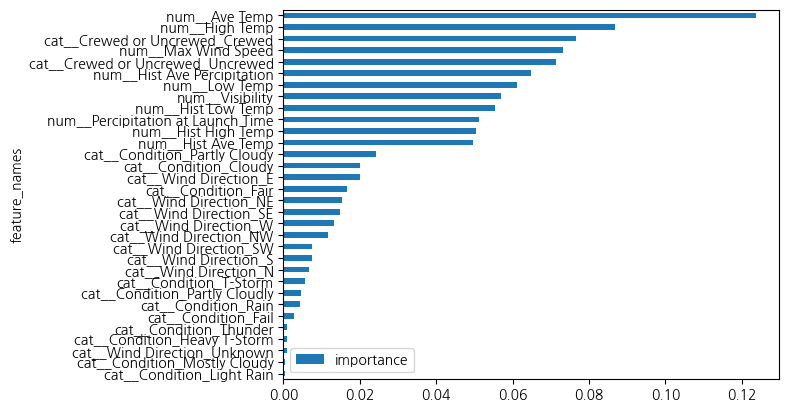

In [16]:
# ------------------------------
# 모델이 학습한 결과 확인 - 특성의 중요도 시각화
# ------------------------------
df_result = pd.DataFrame()
df_result['feature_names'] = feature_names
df_result['importance'] = importance
df_result.sort_values('importance').plot(kind='barh', x='feature_names')